[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.sql import SparkSession, udf
from pyspark.sql.functions import to_timestamp, datediff
from pyspark.sql.types import IntegerType, FloatType, DoubleType, BooleanType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:
#spark1 = SparkSession.builder.getOrCreate()

spark = SparkSession.builder.appName('gh-churn').getOrCreate()
first_period = spark.read.csv('events_data/events_2016_01_01_2016_06_01.csv', header = True, inferSchema = True)
first_period.printSchema()

root
 |-- actor: string (nullable = true)
 |-- event_count: integer (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- CheckRunEvent_count: integer (nullable = true)
 |-- CheckSuiteEvent_count: integer (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- ContentReferenceEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- DeploymentEvent_count: integer (nullable = true)
 |-- DeploymentStatusEvent_count: integer (nullable = true)
 |-- DownloadEvent_count: integer (nullable = true)
 |-- FollowEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- ForkApplyEvent_count: integer (nullable = true)
 |-- asGitHubAppAuthorizationEvent_count: integer (nullable = true)
 |-- GistEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer (nullable = true)
 |-- InstallationEvent_

In [3]:
pd.DataFrame(first_period.take(5), columns=first_period.columns)

,actor,event_count,last_event,first_event,CheckRunEvent_count,CheckSuiteEvent_count,CommitCommentEvent_count,ContentReferenceEvent_count,CreateEvent_count,DeleteEvent_count,...,PushEvent_count,ReleaseEvent_count,RepositoryEvent_count,RepositoryImportEvent_count,RepositoryVulnerabilityAlertEvent_count,SecurityAdvisoryEvent_count,StatusEvent_count,TeamEvent_count,TeamAddEvent_count,WatchEvent_count
0,luceiro,1,2016-02-29 16:42:12 UTC,2016-02-29 16:42:12 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sweilemj,1,2016-02-24 21:37:39 UTC,2016-02-24 21:37:39 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,JimHallett,1,2016-03-03 05:03:29 UTC,2016-03-03 05:03:29 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SecurNET,1,2016-03-03 22:20:06 UTC,2016-03-03 22:20:06 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,mruthvend2l,1,2016-02-23 21:12:11 UTC,2016-02-23 21:12:11 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
first_period.count()

3699852

In [5]:
second_period = spark.read.csv('events_data/events_2016_06_02_2016_11_01_01.csv', header = True, inferSchema = True)
pd.DataFrame(second_period.take(5), columns=second_period.columns)

,actor,event_count,last_event,first_event,CheckRunEvent_count,CheckSuiteEvent_count,CommitCommentEvent_count,ContentReferenceEvent_count,CreateEvent_count,DeleteEvent_count,...,PushEvent_count,ReleaseEvent_count,RepositoryEvent_count,RepositoryImportEvent_count,RepositoryVulnerabilityAlertEvent_count,SecurityAdvisoryEvent_count,StatusEvent_count,TeamEvent_count,TeamAddEvent_count,WatchEvent_count
0,tcastellanos,256,2016-10-14 22:10:05 UTC,2016-06-02 16:38:40 UTC,0,0,0,0,0,0,...,256,0,0,0,0,0,0,0,0,0
1,xamarcade,256,2016-10-28 20:09:36 UTC,2016-06-04 16:04:19 UTC,0,0,0,0,0,0,...,256,0,0,0,0,0,0,0,0,0
2,sophron,256,2016-11-01 21:35:12 UTC,2016-06-09 18:07:54 UTC,0,0,0,0,0,0,...,40,0,0,0,0,0,0,0,0,1
3,hyman720,1,2016-06-08 15:40:36 UTC,2016-06-08 15:40:36 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,gmleahy57,1,2016-06-06 12:54:00 UTC,2016-06-06 12:54:00 UTC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
users = spark.read.csv('all_users.csv', header=True, inferSchema=True)
users = users.drop('event_count').drop('last_event').drop('first_event').drop('_c0')
pd.DataFrame(users.take(5), columns=users.columns)

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,time_between_first_last_event,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23
0,06Birch,0,0,None,None,2016-02-08 11:19:54+00:00,0,0,None,2016-02-08 11:19:54+00:00,0 days 00:19:06.000000000,None,None,None,None,None,None,None,None,None
1,06peng,78,27,http://06peng.com,None,2013-07-25 13:43:38+00:00,1,0,True,2019-01-08 01:55:29+00:00,147 days 07:31:20.000000000,None,None,None,None,None,None,None,None,None
2,0p3ns0urc3,0,0,None,None,2016-04-13 22:30:01+00:00,2,0,None,2016-04-13 22:30:01+00:00,2 days 17:17:36.000000000,None,None,None,None,None,None,None,None,None
3,100341976,0,0,None,None,2016-06-01 19:30:21+00:00,0,0,None,2016-06-01 20:31:02+00:00,0 days 01:16:16.000000000,None,None,None,None,None,None,None,None,None
4,100amps,0,0,None,None,2016-03-24 05:53:08+00:00,0,0,None,2016-05-28 03:05:32+00:00,0 days 00:16:47.000000000,None,None,None,None,None,None,None,None,None


In [167]:
churn_data = users.join(first_period, users['login'] == first_period['actor'], how='left')
pd.DataFrame(churn_data.take(5), columns=churn_data.columns)

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,PushEvent_count,ReleaseEvent_count,RepositoryEvent_count,RepositoryImportEvent_count,RepositoryVulnerabilityAlertEvent_count,SecurityAdvisoryEvent_count,StatusEvent_count,TeamEvent_count,TeamAddEvent_count,WatchEvent_count
0,magnusfriis,0,0,None,None,2015-10-19 13:32:59+00:00,0,0,None,2018-05-01 20:27:16+00:00,...,59,0,0,0,0,0,0,0,0,0
1,100341976,0,0,None,None,2016-06-01 19:30:21+00:00,0,0,None,2016-06-01 20:31:02+00:00,...,0,0,0,0,0,0,0,0,0,0
2,mahabub0,0,0,None,None,2016-02-15 01:47:02+00:00,1,0,None,2016-02-15 01:47:02+00:00,...,0,0,0,0,0,0,0,0,0,0
3,06peng,78,27,http://06peng.com,None,2013-07-25 13:43:38+00:00,1,0,True,2019-01-08 01:55:29+00:00,...,0,0,0,0,0,0,0,0,0,42
4,colton5007,2,0,None,None,2013-11-30 02:35:52+00:00,9,0,True,2019-01-16 01:01:25+00:00,...,100,0,0,0,0,0,0,0,0,0


In [168]:
second_period_event_count = second_period.selectExpr("actor as login",
                                                     "event_count as second_period_event_count")
second_period_event_count.describe().show()

+-------+--------------------+-------------------------+
|summary|               login|second_period_event_count|
+-------+--------------------+-------------------------+
|  count|             3947787|                  3947788|
|   mean|            Infinity|       33.778560550870516|
| stddev|                 NaN|       1701.2997291277995|
|    min|                   0|                        0|
|    max|zzzzzzzzzzzzzzzzz...|                  2713263|
+-------+--------------------+-------------------------+



In [169]:
churn_data = churn_data.join(second_period_event_count, on='login', how='left')

In [170]:
churn_data = churn_data.withColumn("first_event", to_timestamp(churn_data.first_event))
churn_data = churn_data.withColumn("last_event", to_timestamp(churn_data.last_event))
churn_data = churn_data.withColumn("created_at", to_timestamp(churn_data.created_at))
churn_data = churn_data.withColumn("updated_at", to_timestamp(churn_data.updated_at))

In [171]:
churn_data = churn_data.withColumn("time_between_first_last_event", 
                                   datediff(churn_data.last_event, churn_data.first_event))

In [172]:
churn_data = churn_data.withColumn("public_repos_count", churn_data.public_repos_count.cast(IntegerType()))
churn_data = churn_data.withColumn("public_gists_count", churn_data.public_gists_count.cast(IntegerType()))

In [173]:
churn_data = churn_data.fillna(0, subset='second_period_event_count')

In [174]:
f_udf=udf.UserDefinedFunction(lambda x: 1 if x is not None else 0, IntegerType())

churn_data = churn_data.withColumn("blog", f_udf(churn_data.blog))
churn_data = churn_data.withColumn("company", f_udf(churn_data.company))
churn_data = churn_data.withColumn("hireable", f_udf(churn_data.hireable))


In [175]:
pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()

,0,1,2,3,4
login,0loky0,13246864965,1xPdd,2582056905xy,277542952
followers_count,0,0,0,2,1
following_count,1,0,0,6,28
blog,0,0,0,0,0
company,0,0,0,0,0
created_at,2011-05-24 16:15:25,2016-04-14 06:04:50,2014-07-10 23:45:56,2014-04-24 10:51:26,2016-03-15 23:17:58
public_repos_count,7,3,0,35,1
public_gists_count,0,0,0,0,0
hireable,1,0,0,0,0
updated_at,2019-01-09 10:03:59,2018-08-02 03:48:44,2018-12-15 19:55:16,2018-10-17 21:47:18,2017-08-14 15:48:16


In [176]:
churn_data = churn_data.select('login', 'followers_count', 'following_count', 'blog',
               'company', 'created_at', 'public_repos_count', 'public_gists_count',
               'hireable',
               #'updated_at', 'time_between_first_last_event', 'last_event', 'first_event',
               #'event_count', 
               'second_period_event_count',
               'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 
               'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count',
               'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 
               'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count',
               'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count')
cols = churn_data.columns
churn_data.printSchema()

root
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- second_period_event_count: integer (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer (nullable = true)
 |-- IssueCommentEvent_count: integer (nullable = true)
 |-- IssuesEvent_count: integer (nullable = true)
 |-- MemberEvent_count: integer (nullable = true)
 |-- PublicEvent_count: integer (nullable = true)
 |-- PullRequestEvent_count: integer (nullable = true)
 |-- PullRequestReviewC

In [187]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int']
churn_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers_count,169197,6.743328782425221,89.14794363996923,0,20127
following_count,169197,6.155806545033304,332.4167755412179,0,129323
blog,169197,0.18155168235843425,0.38547574139945723,0,1
company,169197,0.16830676666843974,0.3741395812851239,0,1
public_repos_count,169099,13.02582510836847,62.10878703146945,0,18856
public_gists_count,169179,1.7187535095963447,11.722647924288774,0,1291
hireable,169197,0.10457041200494098,0.3059999907713921,0,1
second_period_event_count,169197,32.38565104582233,412.6105932618896,0,116430
CommitCommentEvent_count,169185,0.18196057570115554,5.510081626004566,0,1837


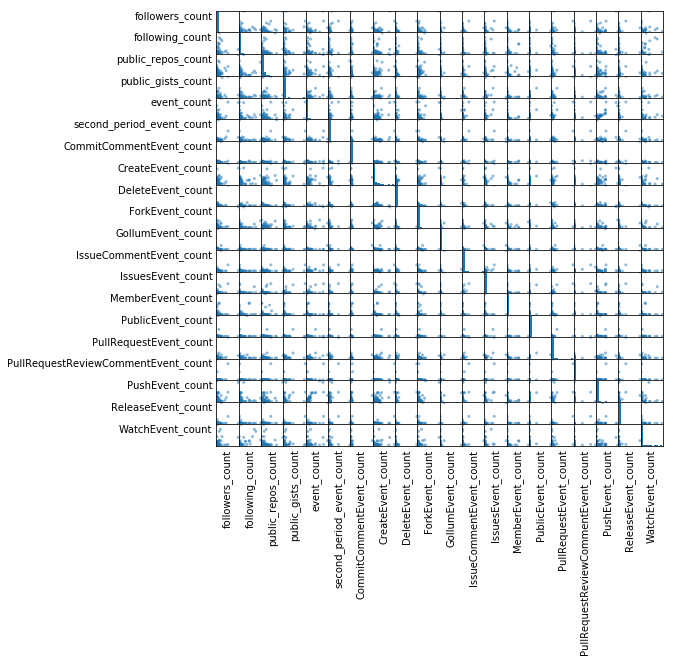

In [86]:
numeric_data = churn_data.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data[:200], figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [191]:
numeric_features.remove('second_period_event_count')
print(numeric_features)

['followers_count', 'following_count', 'blog', 'company', 'public_repos_count', 'public_gists_count', 'hireable', 'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count', 'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count', 'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count']


In [192]:

'''categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

    '''

stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, inputCol="second_period_event_count", outputCol="label")

stages += [binarizer]
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [193]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- second_period_event_count: double (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer (nullable = true)
 |-- IssueCommentEvent_count: integer (nullable = true)
 |-- IssuesEvent_count: integer (nullable = true)
 |-- MemberEvent_count: integer (nullable = true)
 |-- PublicEvent_count: integer (nullable = true)
 |

In [194]:
pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()

,0,1,2,3,4
label,0,1,1,1,0
features,"(0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 5.0, ...","(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 6.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0,...","(1.0, 28.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
login,0loky0,13246864965,1xPdd,2582056905xy,277542952
followers_count,0,0,0,2,1
following_count,1,0,0,6,28
blog,0,0,0,0,0
company,0,0,0,0,0
created_at,2011-05-24 16:15:25,2016-04-14 06:04:50,2014-07-10 23:45:56,2014-04-24 10:51:26,2016-03-15 23:17:58
public_repos_count,7,3,0,35,1
public_gists_count,0,0,0,0,0


In [195]:

train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 118247
Test Dataset Count: 50840


In [196]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

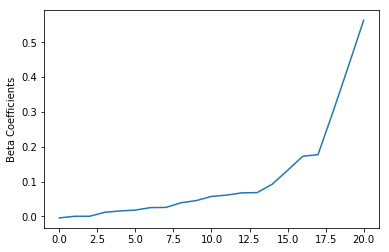

Param(parent='LogisticRegression_0814962b2c33', name='featuresCol', doc='features column name')

In [197]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
lrModel.featuresCol

In [198]:
pd.DataFrame({'features': numeric_features, 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
3,company,0.563238
2,blog,0.431489
6,hireable,0.301870
20,WatchEvent_count,0.177348
19,ReleaseEvent_count,0.172669
5,public_gists_count,0.132181
15,PublicEvent_count,0.092666
4,public_repos_count,0.068318
7,CommitCommentEvent_count,0.067588
10,ForkEvent_count,0.061143


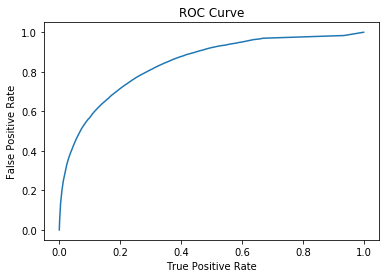

Training set areaUnderROC: 0.8412030675496559


In [199]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

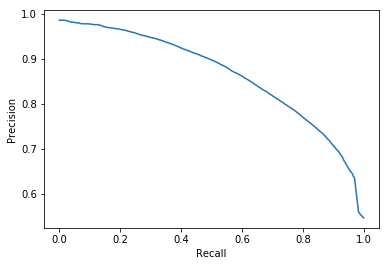

In [200]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [201]:
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'public_repos_count', 'PushEvent_count', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(150)

+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|followers_count|public_repos_count|PushEvent_count|label|       rawPrediction|prediction|         probability|
+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|              5|                 2|              3|  0.0|[-0.7097996902526...|       1.0|[0.32964310283359...|
|            323|                 9|              0|  0.0|[-5.6573869310118...|       1.0|[0.00347947980293...|
|              2|                13|              0|  0.0|[-13.621016521581...|       1.0|[1.21469476339469...|
|              1|                17|              2|  0.0|[-1.1491856019146...|       1.0|[0.24063786762384...|
|              2|                 2|              2|  0.0|[0.25161373632304...|       0.0|[0.56257365646007...|
|             10|                13|             21|  0.0|[-1.9571842325414...|       1.0|[0.12377210141

In [202]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [203]:
predictions = rfModel.transform(test)
predictions.select(show_cols).show(150)

+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|followers_count|public_repos_count|PushEvent_count|label|       rawPrediction|prediction|         probability|
+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|              5|                 2|              3|  0.0|[9.20535821970822...|       1.0|[0.46026791098541...|
|            323|                 9|              0|  0.0|[4.90086855994841...|       1.0|[0.24504342799742...|
|              2|                13|              0|  0.0|[4.39376611207986...|       1.0|[0.21968830560399...|
|              1|                17|              2|  0.0|[4.60845305166261...|       1.0|[0.23042265258313...|
|              2|                 2|              2|  0.0|[9.91827213171682...|       1.0|[0.49591360658584...|
|             10|                13|             21|  0.0|[3.29924955519705...|       1.0|[0.16496247775

In [204]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(
    predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8555796108798478


In [205]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)

In [206]:
predictions = gbtModel.transform(test)
predictions.select(show_cols).show(150)

+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|followers_count|public_repos_count|PushEvent_count|label|       rawPrediction|prediction|         probability|
+---------------+------------------+---------------+-----+--------------------+----------+--------------------+
|              5|                 2|              3|  0.0|[-0.2876449625143...|       1.0|[0.36001710043685...|
|            323|                 9|              0|  0.0|[-0.3721169033081...|       1.0|[0.32207902146173...|
|              2|                13|              0|  0.0|[-1.1112475759506...|       1.0|[0.09774852651557...|
|              1|                17|              2|  0.0|[-0.2712372125676...|       1.0|[0.36761215588757...|
|              2|                 2|              2|  0.0|[0.26120647795969...|       0.0|[0.62771182278241...|
|             10|                13|             21|  0.0|[-1.1887115942833...|       1.0|[0.08491057191

In [207]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8652834823582827


In [208]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

KeyboardInterrupt: 